# Определение возраста покупателей

## Исследовательский анализ данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

Импортировали необходимые библиотеки.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

data_generator = ImageDataGenerator(rescale=1./255)

data_gen_flow = data_generator.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Создали `ImageDataGenerator` и загрузили из папки фото, предварительно указав путь к labels.

In [4]:
print('Количество изображений:', len(labels))

Количество изображений: 7591


Вывели размер датасета.

Имеющихся данных может быть недостаточно для решения задачи определения возраста по фотографиям, так как для задачи регрессии требуется большое количество разнообразных данных для обучения модели. Тем более когда дело касается использвания нейросети для определения возраста для продажи алкоголя. 

Для улучшения качества модели можно использовать аугментацию данных: это позволяет увеличить разнообразие данных, не создавая новых фотографий. Например, можно применять случайные повороты, сдвиги, изменения яркости и т.д.

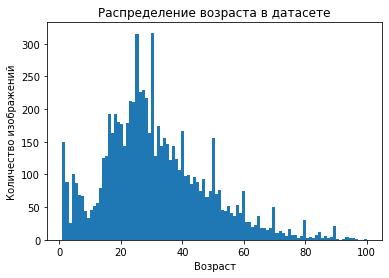

In [5]:
plt.hist(labels['real_age'], bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.title('Распределение возраста в датасете')
plt.show()


График пытается быть похожим на нормальное распределение.

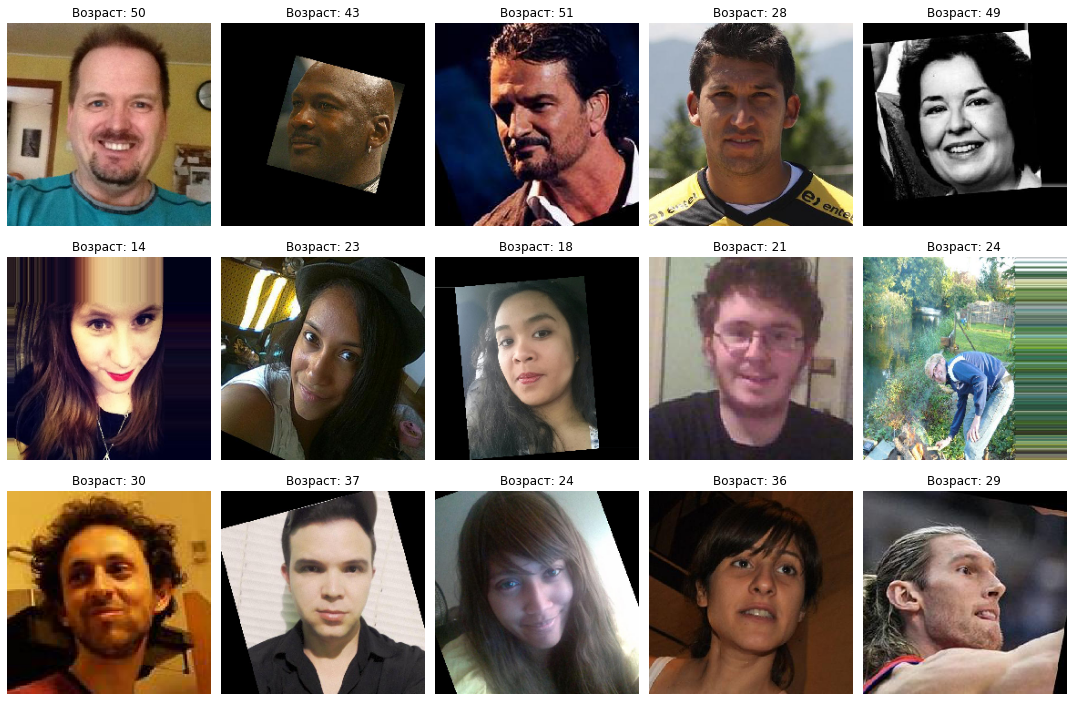

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    img = data_gen_flow[i][0][0]
    age = data_gen_flow[i][1][0]
    ax.imshow(img)
    ax.set_title(f"Возраст: {age}")
    ax.axis('off')
plt.tight_layout()
plt.show()

Вывели 15 фотографий (только посмотрите, какие все красавцы).


Гистограмма распределения возраста показывает, что набор данных перекошен в сторону более молодого возраста, с пиком около 25-30 лет. Это может повлиять на производительность модели, поскольку из-за недостатка обучающих примеров она может с трудом точно предсказывать более старшие возрасты.

15 образцов изображений, показанных в последнем блоке, выглядят визуально разнообразными, что является хорошим признаком того, что набор данных является репрезентативным для реальных данных и может помочь модели изучить значимые характеристики.


## Обучение модели

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=90,
        validation_split=0.25,
        width_shift_range=0.2,
        height_shift_range=0.2
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=90,
        validation_split=0.25,
        width_shift_range=0.2,
        height_shift_range=0.2
    )
    test_data_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_data_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model


```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 123s - loss: 263.7628 - mae: 11.9872 - val_loss: 726.7887 - val_mae: 22.0370
Epoch 2/10
356/356 - 109s - loss: 138.8621 - mae: 9.0102 - val_loss: 200.4154 - val_mae: 10.8288
Epoch 3/10
356/356 - 107s - loss: 122.9322 - mae: 8.4224 - val_loss: 145.5776 - val_mae: 9.2010
Epoch 4/10
356/356 - 108s - loss: 105.0781 - mae: 7.8403 - val_loss: 120.2237 - val_mae: 8.2826
Epoch 5/10
356/356 - 109s - loss: 97.7813 - mae: 7.5500 - val_loss: 100.2381 - val_mae: 7.4713
Epoch 6/10
356/356 - 108s - loss: 86.9715 - mae: 7.1225 - val_loss: 98.1660 - val_mae: 7.5683
Epoch 7/10
356/356 - 108s - loss: 81.3180 - mae: 6.8937 - val_loss: 99.6773 - val_mae: 7.5082
Epoch 8/10
356/356 - 108s - loss: 77.8071 - mae: 6.7092 - val_loss: 122.2129 - val_mae: 8.0768
Epoch 9/10
356/356 - 108s - loss: 69.7968 - mae: 6.4006 - val_loss: 95.6434 - val_mae: 7.4859
Epoch 10/10
356/356 - 113s - loss: 67.2072 - mae: 6.2894 - val_loss: 101.8698 - val_mae: 7.6720
119/119 - 31s - loss: 99.7962 - mae: 7.6501
Test MAE: 7.6501



```

## Анализ обученной модели

Задача заключалась в построении модели, которая могла бы оценить возраст человека по фотографии. Модель была создана с помощью сверточной нейронной сети с предварительно обученной основой ResNet-50 и кастомной головой. Веса для ResNet-50 были предзагружены. Размер батча составил 16. Модель была обучена на наборе изображений с соответствующими возрастными метками с помощью Adam (стохастического метода градиентного спуска) со скоростью обучения 0.0001. Веса бэкбона заморожены во время обучения не были, модель обучалась в течение 10 эпох.

Обучающая выборка была дополнена с помощью различных методов аугментации, включая вращение, сдвиг по ширине и высоте, и валидационное разбиение в размере 25%.

В процессе обучения модель достигала MAE 6.28 на обучающей выборке и MAE 7.47 на проверочном множестве. Переобучения замечено не было (возможно, при большем количестве эпох это бы произошло).

Итоговое тестовое значение MAE (средняя абсолютная ошибка) модели составило 7.65, что говорит о том, что модель работает относительно хорошо. Тем не менее все ещё существуют некоторые потенциальные риски, которые необходимо учитывать. Например, модель может не точно оценить возраст людей с определенными физическими характеристиками или тех, чей внешний вид значительно отличается от изображений в обучающем наборе. Кроме того, модель может оказаться ненадежной при применении к изображениям с плохим освещением или низким качеством изображения.

В целом, модель представляется перспективным инструментом для оценки возраста людей на фотографиях, но ее ограничения следует учитывать при применении в реальных сценариях, таких как продажа алкоголя. Тогда как предложение товаров для определенной возрастной группы на основе изображений лиц можно ввести в качестве эксперимента.